# Multi-class Classification

In [3]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## Getting and checking the data

In [4]:
# Get data
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

train_ds = './sign_mnist_train.csv'
val_ds = './sign_mnist_test.csv'


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 93.4MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 105MB/s] 


In [5]:
# Check datasets
with open(train_ds, 'r') as f:
  print('Dataset header looks like this:\n', f.readline())
  print('Dataset record looks like this:\n', f.readline())

Dataset header looks like this:
 label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel11

## Parsing the dataset

In [6]:
# Parse the dataset
def parse_dataset(ds):
  """
  Parse the dataset
  to images and labels.

  Args:
    ds (str): Path to a dataset csv-file
  Returns:
    labels, images: A tuple of numpy arrays
      containing labels and images
  """

  with open(ds, 'r') as f:
    reader, labels, images = csv.reader(f), [], []
    next(reader)
    for row in reader:
      labels.append(row[0])
      images.append(row[1:])
  labels = np.array(labels, dtype='f')
  images = np.array(images, dtype='f').reshape(len(labels), 28, 28)

  return labels, images


train_labels, train_images = parse_dataset(train_ds)
val_labels, val_images = parse_dataset(val_ds)
print(f"Training images dataset has shape: {train_images.shape} and data type: {train_images.dtype}")
print(f"Training labels dataset has shape: {train_labels.shape} and data type: {train_labels.dtype}")
print(f"Validation images dataset has shape: {val_images.shape} and data type: {val_images.dtype}")
print(f"Validation labels dataset has shape: {val_labels.shape} and data type: {val_labels.dtype}")

Training images dataset has shape: (27455, 28, 28) and data type: float32
Training labels dataset has shape: (27455,) and data type: float32
Validation images dataset has shape: (7172, 28, 28) and data type: float32
Validation labels dataset has shape: (7172,) and data type: float32


## Visualizing the numpy arrays

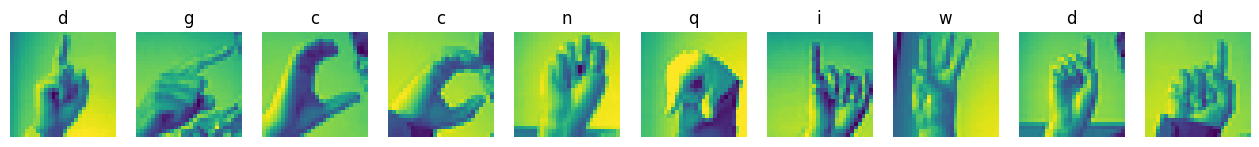

In [7]:
# Plot a sample of 10 images from the training dataset
import string

letters = list(string.ascii_lowercase)
plt.figure(figsize=(16,5))
for i in range(10):
  s = plt.subplot(1, 10, i+1)
  img_arr = np.expand_dims(train_images[i], axis=-1)
  img = array_to_img(img_arr)
  s.set_axis_off()
  s.set_title(letters[int(train_labels[i])])
  s.imshow(img)

## Creating image data generators for a CNN

In [8]:
# Get train and validation image data generators
def get_generator(labels, images, train=True):
  images = np.expand_dims(images, axis=-1)
  if train:
    datagen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
    )
  else:
    datagen = ImageDataGenerator(rescale=1/255)

  generator = datagen.flow(
      x=images,
      y=labels,
      batch_size=32,
  )
  return generator

train_gen = get_generator(train_labels, train_images)
val_gen = get_generator(val_labels, val_images, train=False)
print(f"Images of training generator have shape: {train_gen.x.shape}")
print(f"Labels of training generator have shape: {train_gen.y.shape}")
print(f"Images of validation generator have shape: {val_gen.x.shape}")
print(f"Labels of validation generator have shape: {val_gen.y.shape}")


Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Building and training the CNN

In [9]:
# Build a model
def build_model():
  model = tf.keras.models.Sequential([
      Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
      MaxPooling2D(2, 2),
      Conv2D(128, (3, 3), activation='relu'),
      MaxPooling2D(2, 2),
      Flatten(),
      Dense(512, activation='relu'),
      Dropout(0.2),
      Dense(26)
  ])
  model.compile(
      loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer='adam',
      metrics=['accuracy'],
  )
  return model

In [10]:
# Train the model
model = build_model()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
)

Epoch 1/15
858/858 [==============================] - 25s 16ms/step - loss: 1.3669 - accuracy: 0.5698 - val_loss: 0.2819 - val_accuracy: 0.9204
Epoch 2/15
858/858 [==============================] - 14s 16ms/step - loss: 0.4435 - accuracy: 0.8549 - val_loss: 0.1049 - val_accuracy: 0.9702
Epoch 3/15
858/858 [==============================] - 14s 16ms/step - loss: 0.2546 - accuracy: 0.9162 - val_loss: 0.0528 - val_accuracy: 0.9858
Epoch 4/15
858/858 [==============================] - 14s 17ms/step - loss: 0.1663 - accuracy: 0.9453 - val_loss: 0.0458 - val_accuracy: 0.9845
Epoch 5/15
858/858 [==============================] - 14s 16ms/step - loss: 0.1255 - accuracy: 0.9586 - val_loss: 0.0221 - val_accuracy: 0.9936
Epoch 6/15
858/858 [==============================] - 15s 18ms/step - loss: 0.1071 - accuracy: 0.9656 - val_loss: 0.0165 - val_accuracy: 0.9933
Epoch 7/15
858/858 [==============================] - 14s 17ms/step - loss: 0.0948 - accuracy: 0.9694 - val_loss: 0.0181 - val_accuracy:

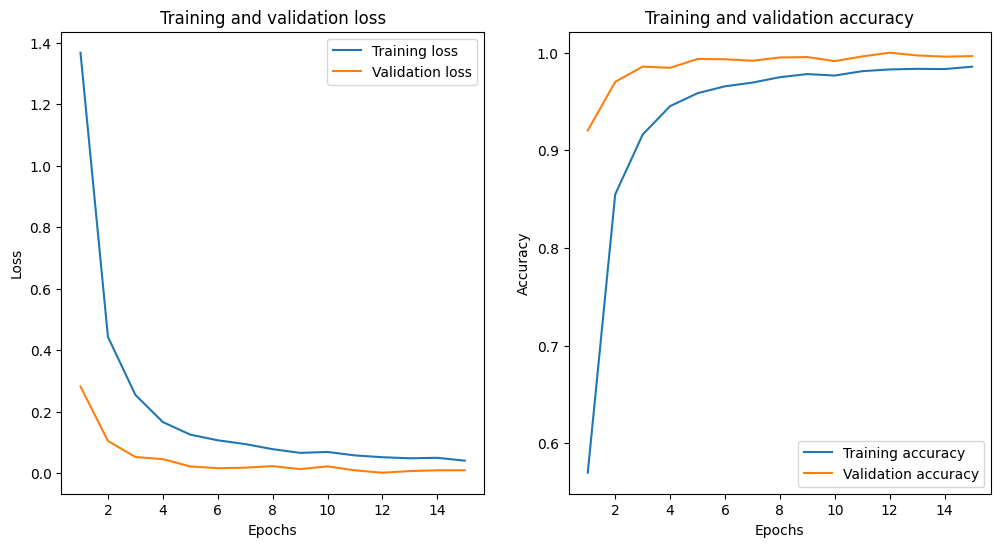

In [11]:
# Plot the model training history
from math import ceil

def plot_history(params: list[str], val=True):
  num_rows = ceil(len(params)/2)
  epochs = [epoch for epoch in range(1, len(history.history[params[0]])+1)]
  plt.figure(figsize=(12, 6*num_rows))
  for i in range(len(params)):
    s = plt.subplot(num_rows, 2, i+1)
    par = params[i]
    s.plot(epochs, history.history[par], label=f'Training {par}')
    s.set_xlabel('Epochs')
    s.set_ylabel(par.capitalize())
    if val:
      s.plot(epochs, history.history[f'val_{par}'], label=f'Validation {par}')
      s.set_title(f'Training and validation {par}')
    else:
      s.set_title(f'Training {par}')
    s.legend()

plot_history(['loss', 'accuracy'])